In [3]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
import os
import tensorflow as tf
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from jupyterthemes import jtplot

import nmca_model
from TwoChannelModel import TwoChannelModel
from correlation_analysis import CCA, PCC_Matrix
from plot import plot_eval
from tf_summary import write_image_summary, write_metric_summary

LOGPATH = f'{os.getcwd()}/log'
os.makedirs(LOGPATH)
#jtplot.style(grid=False)

# Generate Data

In [5]:
data_model = TwoChannelModel(num_samples=1000)
y_1, y_2, Az_1, Az_2, z_1, z_2 = data_model('Parabola')

2021-10-12 20:37:09.378709: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


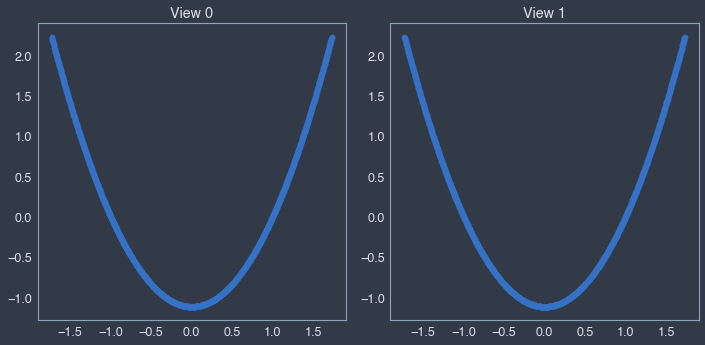

In [6]:
TwoChannelModel.plot_shared_components(z_1, z_2)

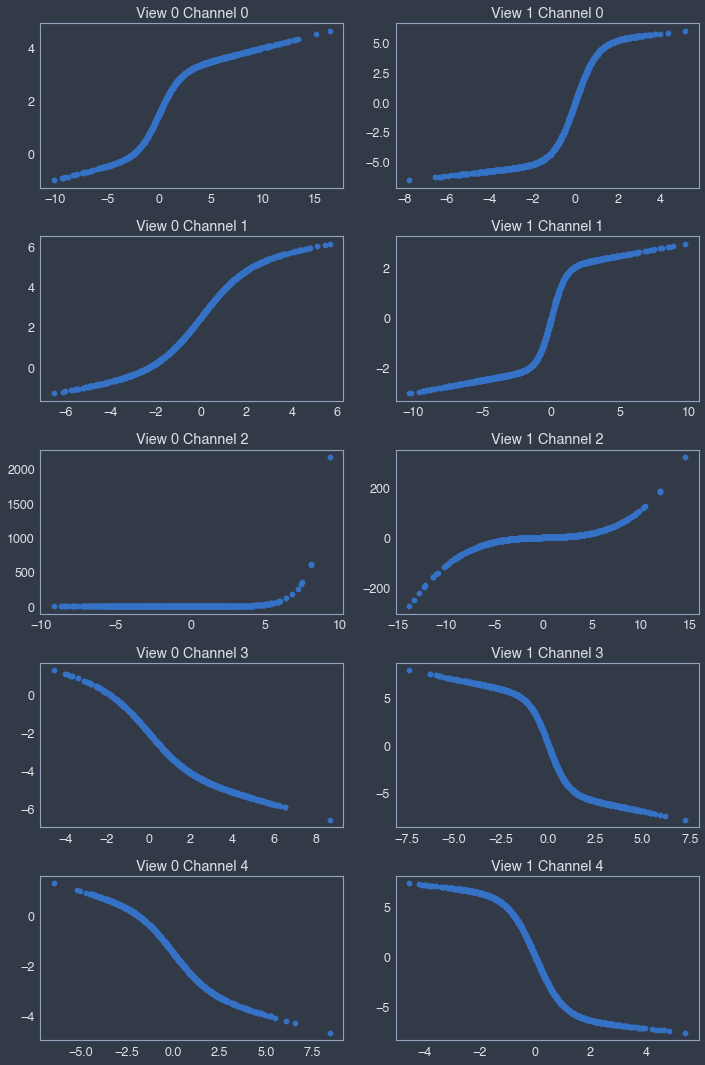

In [7]:
TwoChannelModel.plot_non_linearities(y_1, y_2, Az_1, Az_2)

# Build model

In [8]:
model = nmca_model.build_nmca_model(hdim=256)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.split_1 (TFOpLambda)         [(None, 1), (None, 1 0           input_2[0][0]                    
______________________________________________________________________________________________

# Train one network

In [10]:
writer = nmca_model.create_writer(LOGPATH)
optimizer = tf.keras.optimizers.Adam()

for epoch in tqdm(range(10000), desc='Epochs'):
    with tf.GradientTape() as tape:
        # Watch the input to be able to compute the gradient later
        tape.watch([y_1,y_2])
        # Forward path
        [fy_1, fy_2], [yhat_1, yhat_2] = model([tf.transpose(y_1), tf.transpose(y_2)])
        # Loss computation
        loss, cca_loss, rec_loss, ccor = nmca_model.compute_loss(y_1, y_2, fy_1, fy_2, yhat_1, yhat_2, lambda_reg=1e-10)
        
        if epoch%5 == 0:
            # Compute dist metric
            B1, B2, epsilon, omega, ccor = CCA(fy_1, fy_2, 2)
            dist = nmca_model.compute_distance_metric(S=z_1[:2], U=0.5*(omega+epsilon))
            
            write_metric_summary(writer, epoch, loss, cca_loss, rec_loss, ccor, dist)
        
        if epoch%500 == 0:
            write_image_summary(writer, epoch, Az_1, Az_2, y_1, y_2, fy_1, fy_2)
        
    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Backpropagate through network
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

# Train many networks

In [11]:
num_models = 3
lambda_reg = 1e-10

for N in range(num_models):
    writer = nmca_model.create_grid_writer(LOGPATH, [N, lambda_reg])
    optimizer = tf.keras.optimizers.Adam()
    model = nmca_model.build_nmca_model(256)

    for epoch in tqdm(range(10000), desc='Epochs'):
        with tf.GradientTape() as tape:
            # Watch the input to be able to compute the gradient later
            tape.watch([y_1,y_2])
            # Forward path
            [fy_1, fy_2], [yhat_1, yhat_2] = model([tf.transpose(y_1), tf.transpose(y_2)])
            # Loss computation
            loss, cca_loss, rec_loss, ccor = nmca_model.compute_loss(y_1, y_2, fy_1, fy_2, yhat_1, yhat_2, lambda_reg=lambda_reg)

            if epoch%5 == 0:
                # Compute dist metric
                B1, B2, epsilon, omega, ccor = CCA(fy_1, fy_2, 2)
                dist = nmca_model.compute_distance_metric(S=z_1[:2], U=0.5*(omega+epsilon))

                write_metric_summary(writer, epoch, loss, cca_loss, rec_loss, ccor, dist)

            if epoch%500 == 0:
                write_image_summary(writer, epoch, Az_1, Az_2, y_1, y_2, fy_1, fy_2)

        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Backpropagate through network
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

# Eval network

In [12]:
# Forward path
[fy_1, fy_2], [yhat_1, yhat_2] = model([tf.transpose(y_1), tf.transpose(y_2)])

# Compute CCA
B1, B2, epsilon, omega, ccor = CCA(fy_1, fy_2, 2)

fy_1, fy_2 = tf.transpose(fy_1), tf.transpose(fy_2)
yhat_1, yhat_2 = tf.transpose(yhat_1), tf.transpose(yhat_2)

In [13]:
S = z_1[:2]
Ps = np.eye(1000) - tf.transpose(S)@np.linalg.inv(S@tf.transpose(S))@S
U = 0.5*(omega+epsilon)
Q = scipy.linalg.orth(tf.transpose(U))
dist = np.linalg.norm(Ps@Q, ord=2)
print("Dist: "+str(dist))

Dist: 0.20103884


--------------------------
Reconstruction performance
--------------------------


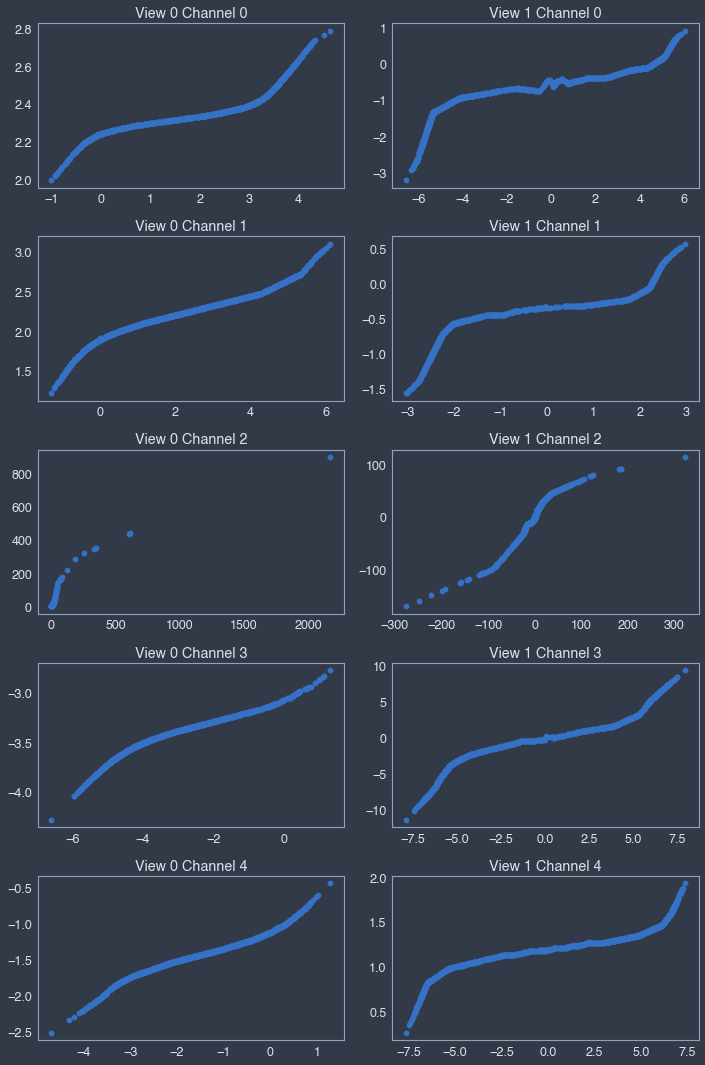

--------------------------
Inverse learning
--------------------------


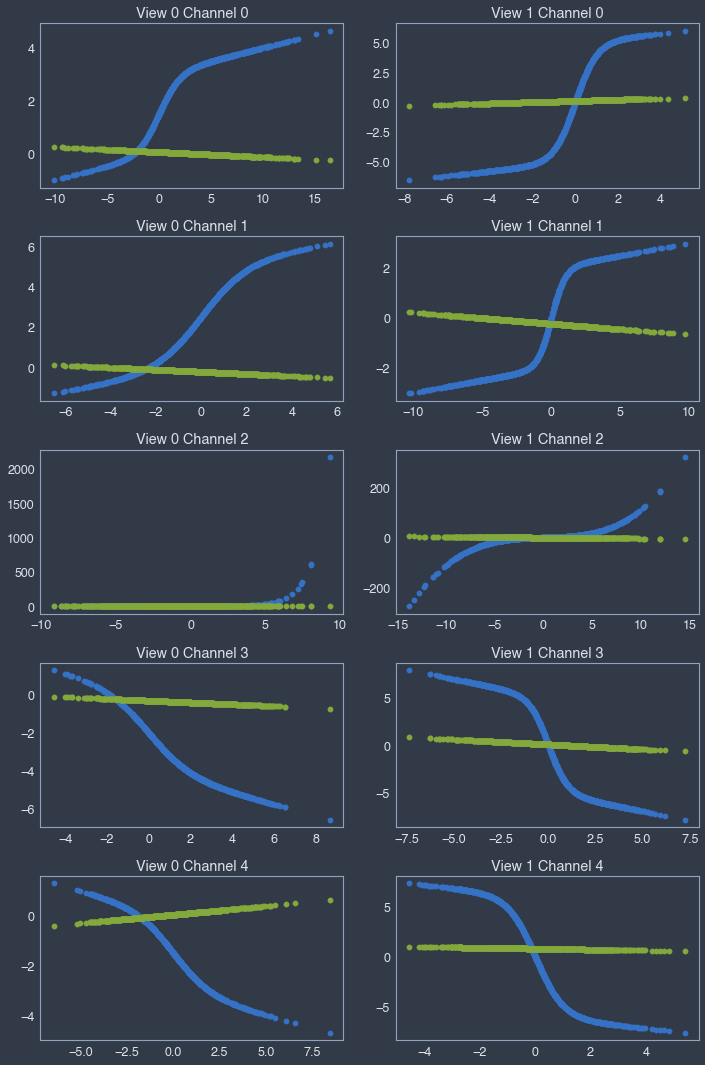

--------------------------
Estimated sources
--------------------------


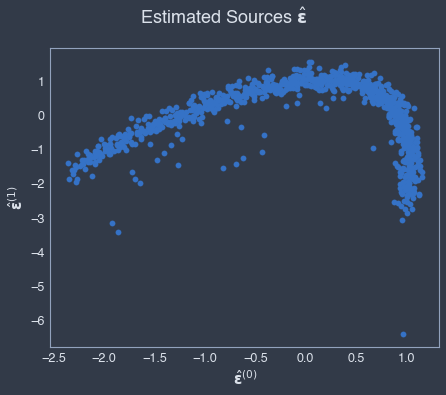

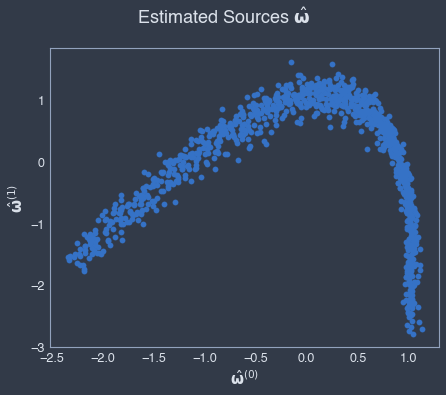

--------------------------
Estimated and true sources
--------------------------


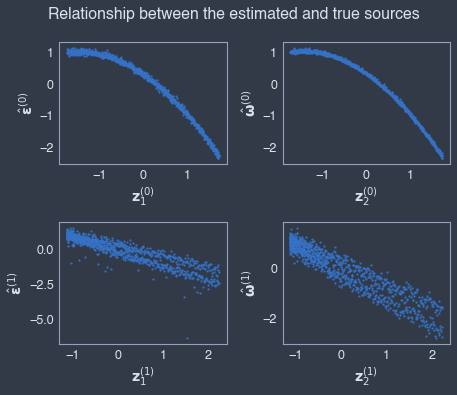

--------------------------
PCC matrices
--------------------------


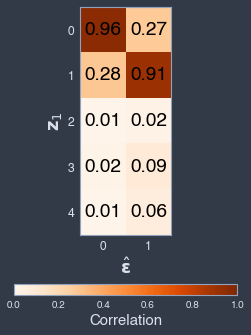

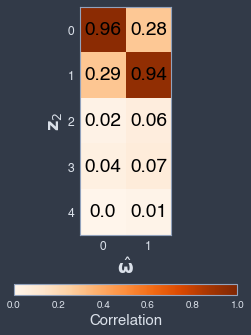

In [14]:
plot_eval(z_1, z_2, Az_1, Az_2, y_1, y_2, fy_1, fy_2, yhat_1, yhat_2, epsilon, omega)